# Импорты

In [1]:
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchsummary import summary

from src.data.dataset import TableDataset
from src.util.util import enumerateWithEstimate
from src.training import TableTrainingApp
from src.models.augmentation import TableAugmentation

# Примеры изображений в наборе данных

Text(0.5, 1.0, 'Чистый стол')

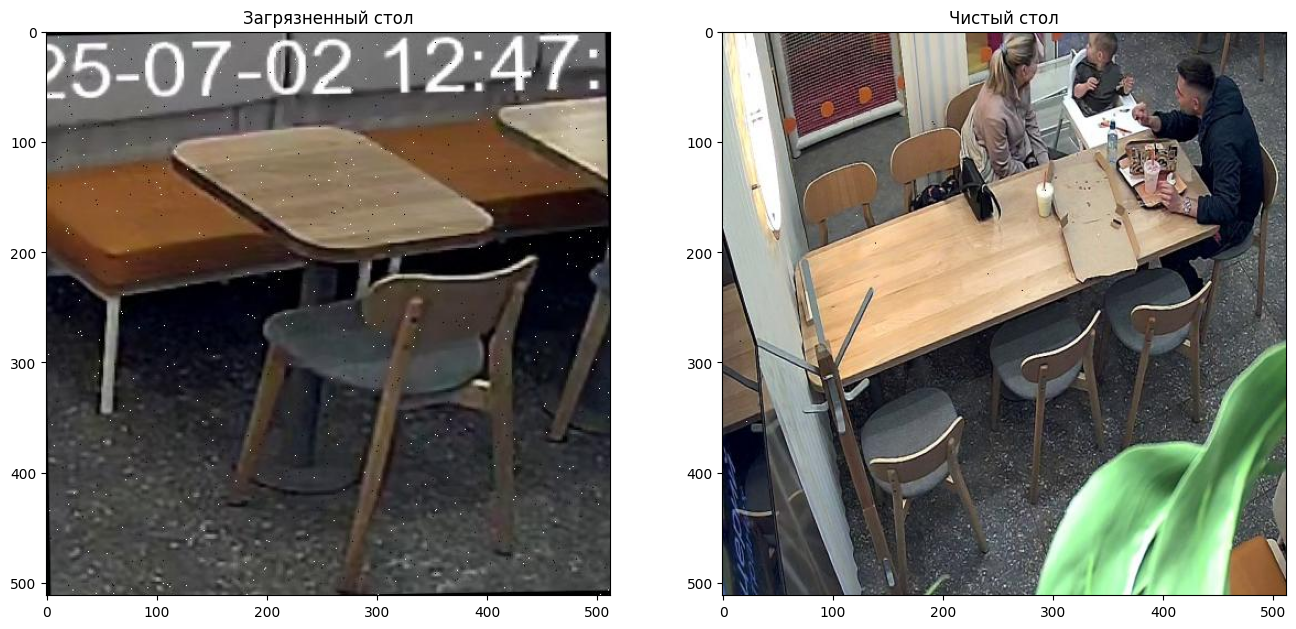

In [ ]:
# Чтение изображения с загрязненным столом
img_dirty = cv2.imread('dataset/clean/table2_frame_00080_jpg.rf.b80b405fe21077c5957c334125d99bb7.jpg')
img_dirty = cv2.cvtColor(img_dirty, cv2.COLOR_BGR2RGB)

# Чтение изображения с загрязненным столом
img_clean = cv2.imread('dataset/dirty/table1_frame_00248_jpg.rf.1efe722426294e857d56c87c3651e0db.jpg')
img_clean = cv2.cvtColor(img_clean, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2, figsize=(16, 16))

plt.subplot(1, 2, 1)
plt.imshow(img_dirty)
plt.title('Загрязненный стол')

plt.subplot(1, 2, 2)
plt.imshow(img_clean)
plt.title('Чистый стол')


# Пример работы с классом TableDataset

## Создание тренировочного набора данных

In [2]:
# Создание тренировочного набора данных с шагом 10 для валидации
data = TableDataset(val_stride=0, isValSet_bool=False)

print(f"Размер тренировочного набора данных: {len(data)}")

Размер тренировочного набора данных: 2535


Размер изображения: torch.Size([3, 280, 280])
Метка класса: tensor([0, 1])


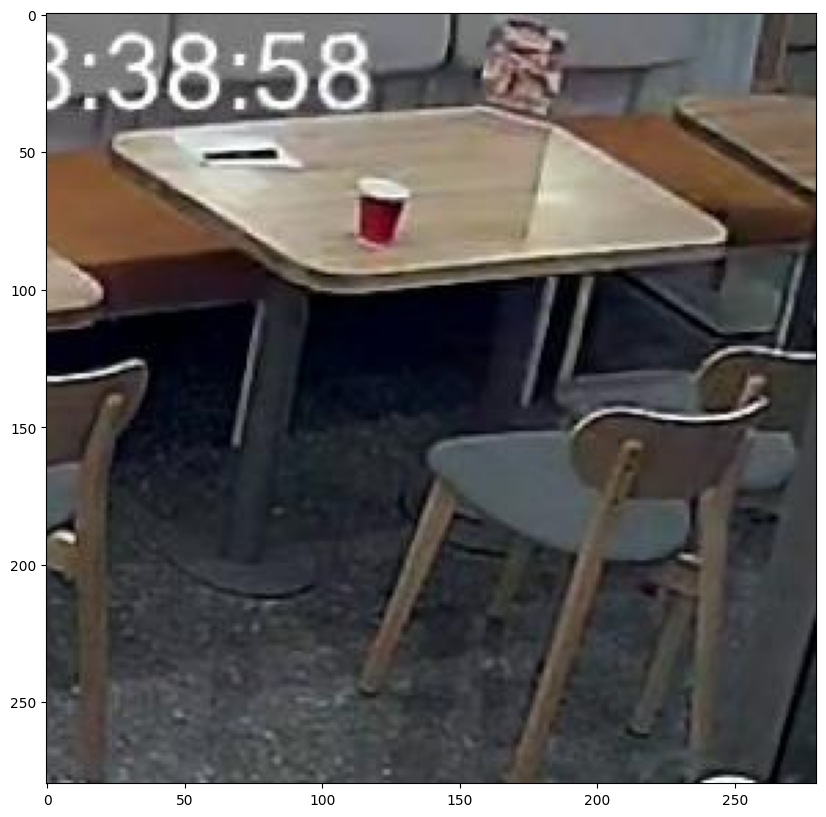

In [3]:
# Получение изображения и метки класса из набора
img_t, target = data[0]

print(f'Размер изображения: {img_t.shape}')
plt.figure(figsize=(10, 10))
plt.imshow(img_t.permute(1, 2, 0))

print(f"Метка класса: {target}")

## Работа генератора с выводом примерного времени ожидания прохода по пакетам

In [4]:
# Создаем DataLoader с размером пакета 64
dl = DataLoader(data, 64, num_workers=6,)

# Создание генератора по dl с выводом примерного времени ожидания
batch_iter = enumerateWithEstimate(dl, "Генератор прошел по", start_ndx=dl.num_workers)

for _ in batch_iter:
    pass

2025-11-09 22:10:23,707 WARNING  pid:36027     src.util.util:031:enumerateWithEstimate Генератор прошел по ----/19, starting
2025-11-09 22:10:24,521 INFO     pid:36027     src.util.util:047:enumerateWithEstimate Генератор прошел по   16/19, done at 2025-11-09 22:10:24, 0:00:00
2025-11-09 22:10:24,645 WARNING  pid:36027     src.util.util:060:enumerateWithEstimate Генератор прошел по ----/19, done at 2025-11-09 22:10:24


# Data Augmentation

Text(0.5, 1.0, 'С применением data augmentation')

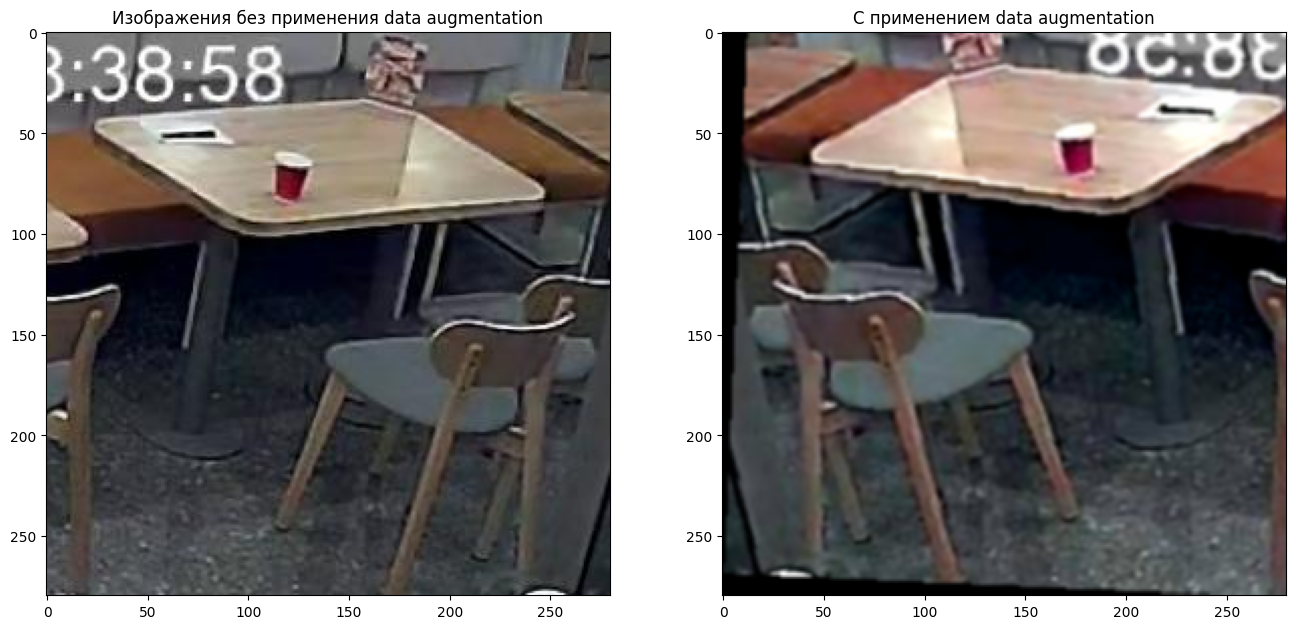

In [6]:
aug_model = TableAugmentation()

fig, axes = plt.subplots(1, 2, figsize=(16, 16))

plt.subplot(1, 2, 1)
plt.imshow(img_t.permute(1, 2, 0))
plt.title('Изображения без применения data augmentation')

plt.subplot(1, 2, 2)
plt.imshow(aug_model(img_t).permute(1, 2, 0))
plt.title('С применением data augmentation')


# Обучение модели на простом блоке

Простой блок состоит только из сверточных слоев и слоев субдискретизации (Max Pooling)

In [2]:
app = TableTrainingApp(['--num-workers=6', '--epoch=20', '--batch-size=32', '--balanced', '--conv-type=simple', '--img-size=280', '--depth=3', 'conv_simple_depth_3'])

2025-11-12 18:43:25,744 INFO     pid:7462     src.training:147:initModel Using CUDA; 1 devices.
2025-11-12 18:43:25,905 INFO     pid:7462     src.training:164:log_memory_usage GPU Memory After model loading:                 0.00GB allocated, 0.02GB reserved


In [3]:
summary(app.model, (3, 280, 280), 64)

/home/himoza/miniconda3/envs/luna16/lib/python3.13/site-packages/torch/nn/functional.py:1531: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1          [64, 3, 280, 280]               6
            Conv2d-2         [64, 32, 280, 280]             896
            Conv2d-3         [64, 32, 280, 280]           9,248
       SimpleBlock-4         [64, 32, 140, 140]               0
            Conv2d-5         [64, 64, 140, 140]          18,496
            Conv2d-6         [64, 64, 140, 140]          36,928
       SimpleBlock-7           [64, 64, 70, 70]               0
            Conv2d-8          [64, 128, 70, 70]          73,856
            Conv2d-9          [64, 128, 70, 70]         147,584
      SimpleBlock-10          [64, 128, 35, 35]               0
           Linear-11                    [64, 2]         313,602
Total params: 600,616
Trainable params: 600,616
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 57.42
Forward

In [4]:
app.main()

2025-11-12 18:43:26,923 INFO     pid:7462     src.training:241:main Starting TableTrainingApp, Namespace(model_type='custom', num_workers=6, batch_size=32, epochs=20, lr=0.001, balanced=True, img_size=280, conv_type='simple', depth=3, checkpoint_dir='./checkpoints', tb_prefix='table', comment='conv_simple_depth_3')
2025-11-12 18:43:26,932 INFO     pid:7462     src.training:248:main Epoch 1 of 20, 157/9 batches of size 32*1
2025-11-12 18:43:26,937 WARNING  pid:7462     src.util.util:031:enumerateWithEstimate E1 Training ----/157, starting
2025-11-12 18:43:42,488 INFO     pid:7462     src.util.util:047:enumerateWithEstimate E1 Training   64/157, done at 2025-11-12 18:44:04, 0:00:35
2025-11-12 18:44:04,108 WARNING  pid:7462     src.util.util:060:enumerateWithEstimate E1 Training ----/157, done at 2025-11-12 18:44:04
2025-11-12 18:44:04,125 INFO     pid:7462     src.training:405:logMetrics E1 TableTrainingApp
2025-11-12 18:44:04,126 INFO     pid:7462     src.training:443:logMetrics E1 trn 

# Обучение на блоке с пакетной нормализацией

In [2]:
app = TableTrainingApp(['--num-workers=6', '--epoch=20', '--batch-size=32', '--balanced', '--lr=0.001', '--conv-type=batch', '--img-size=280', '--depth=3', 'conv_batch_depth_3'])

2025-11-12 19:04:31,503 INFO     pid:11180     src.training:147:initModel Using CUDA; 1 devices.
2025-11-12 19:04:31,684 INFO     pid:11180     src.training:164:log_memory_usage GPU Memory After model loading:                 0.00GB allocated, 0.02GB reserved


In [3]:
summary(app.model, (3, 280, 280), 32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1          [32, 3, 280, 280]               6
            Conv2d-2         [32, 32, 280, 280]             896
            Conv2d-3         [32, 32, 280, 280]           9,248
       BatchNorm2d-4         [32, 32, 280, 280]              64
        BatchBlock-5         [32, 32, 140, 140]               0
            Conv2d-6         [32, 64, 140, 140]          18,496
            Conv2d-7         [32, 64, 140, 140]          36,928
       BatchNorm2d-8         [32, 64, 140, 140]             128
        BatchBlock-9           [32, 64, 70, 70]               0
           Conv2d-10          [32, 128, 70, 70]          73,856
           Conv2d-11          [32, 128, 70, 70]         147,584
      BatchNorm2d-12          [32, 128, 70, 70]             256
       BatchBlock-13          [32, 128, 35, 35]               0
           Linear-14                   

/home/himoza/miniconda3/envs/luna16/lib/python3.13/site-packages/torch/nn/functional.py:1531: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [4]:
app.main()

2025-11-12 19:04:39,102 INFO     pid:11180     src.training:241:main Starting TableTrainingApp, Namespace(model_type='custom', num_workers=6, batch_size=32, epochs=20, lr=0.001, balanced=True, img_size=280, conv_type='batch', depth=3, checkpoint_dir='./checkpoints', tb_prefix='table', comment='conv_batch_depth_3')
2025-11-12 19:04:39,112 INFO     pid:11180     src.training:248:main Epoch 1 of 20, 157/9 batches of size 32*1
2025-11-12 19:04:39,119 WARNING  pid:11180     src.util.util:031:enumerateWithEstimate E1 Training ----/157, starting
2025-11-12 19:04:56,275 INFO     pid:11180     src.util.util:047:enumerateWithEstimate E1 Training   64/157, done at 2025-11-12 19:05:20, 0:00:39
2025-11-12 19:05:20,162 WARNING  pid:11180     src.util.util:060:enumerateWithEstimate E1 Training ----/157, done at 2025-11-12 19:05:20
2025-11-12 19:05:20,183 INFO     pid:11180     src.training:405:logMetrics E1 TableTrainingApp
2025-11-12 19:05:20,184 INFO     pid:11180     src.training:443:logMetrics E1

# Обучение на блоке с Dropout

In [8]:
app = TableTrainingApp(['--num-workers=6', '--epoch=10', '--batch-size=32', '--conv-type=dropout', '--img-size=280', '--depth=3', 'conv_dropout_depth_3'])

2025-11-12 15:54:33,097 INFO     pid:19932     src.training:147:initModel Using CUDA; 1 devices.
2025-11-12 15:54:33,107 INFO     pid:19932     src.training:164:log_memory_usage GPU Memory After model loading:                 0.03GB allocated, 0.08GB reserved


In [9]:
summary(app.model, (3, 280, 280), 16)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1          [16, 3, 280, 280]               6
            Conv2d-2         [16, 32, 280, 280]             896
            Conv2d-3         [16, 32, 280, 280]           9,248
      DropoutBlock-4         [16, 32, 140, 140]               0
            Conv2d-5         [16, 64, 140, 140]          18,496
            Conv2d-6         [16, 64, 140, 140]          36,928
      DropoutBlock-7           [16, 64, 70, 70]               0
            Conv2d-8          [16, 128, 70, 70]          73,856
            Conv2d-9          [16, 128, 70, 70]         147,584
     DropoutBlock-10          [16, 128, 35, 35]               0
           Linear-11                    [16, 2]         313,602
Total params: 600,616
Trainable params: 600,616
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 14.36
Forward

In [10]:
app.main()

2025-11-12 15:54:33,129 INFO     pid:19932     src.training:241:main Starting TableTrainingApp, Namespace(model_type='custom', num_workers=6, batch_size=32, epochs=10, lr=0.001, balanced=False, img_size=280, conv_type='dropout', depth=3, checkpoint_dir='./checkpoints', tb_prefix='table', comment='conv_dropout_depth_3')
2025-11-12 15:54:33,130 INFO     pid:19932     src.training:248:main Epoch 1 of 10, 71/9 batches of size 32*1
2025-11-12 15:54:33,130 WARNING  pid:19932     src.util.util:031:enumerateWithEstimate E1 Training ----/71, starting
2025-11-12 15:54:37,252 INFO     pid:19932     src.util.util:047:enumerateWithEstimate E1 Training   16/71, done at 2025-11-12 15:54:50, 0:00:15
2025-11-12 15:54:41,029 INFO     pid:19932     src.util.util:047:enumerateWithEstimate E1 Training   32/71, done at 2025-11-12 15:54:50, 0:00:15
2025-11-12 15:54:48,622 INFO     pid:19932     src.util.util:047:enumerateWithEstimate E1 Training   64/71, done at 2025-11-12 15:54:50, 0:00:15
2025-11-12 15:54:

KeyboardInterrupt: 

# Обучение на предобученной модели

## Transfer learning

In [3]:
app = TableTrainingApp(['--num-workers=6', '--epoch=20', '--model-type=pretraining', '--balanced', '--batch-size=32', '--lr=0.001', '--img-size=280', 'transfer_learning'])

Downloading: "https://download.pytorch.org/models/efficientnet_b6_lukemelas-24a108a5.pth" to /home/himoza/.cache/torch/hub/checkpoints/efficientnet_b6_lukemelas-24a108a5.pth


KeyboardInterrupt: 

In [3]:
summary(app.model, (3, 280, 280), 32)

NameError: name 'app' is not defined

In [7]:
app.main()

2025-11-12 19:19:49,050 INFO     pid:11180     src.training:241:main Starting TableTrainingApp, Namespace(model_type='pretraining', num_workers=6, batch_size=32, epochs=20, lr=0.001, balanced=True, img_size=224, conv_type='simple', depth=4, checkpoint_dir='./checkpoints', tb_prefix='table', comment='transfer_learning')
2025-11-12 19:19:49,050 INFO     pid:11180     src.training:248:main Epoch 1 of 20, 157/9 batches of size 32*1
2025-11-12 19:19:49,052 WARNING  pid:11180     src.util.util:031:enumerateWithEstimate E1 Training ----/157, starting
2025-11-12 19:19:52,082 INFO     pid:11180     src.util.util:047:enumerateWithEstimate E1 Training   64/157, done at 2025-11-12 19:19:55, 0:00:06
2025-11-12 19:19:55,930 WARNING  pid:11180     src.util.util:060:enumerateWithEstimate E1 Training ----/157, done at 2025-11-12 19:19:55
2025-11-12 19:19:55,933 INFO     pid:11180     src.training:405:logMetrics E1 TableTrainingApp
2025-11-12 19:19:55,934 INFO     pid:11180     src.training:443:logMetri

## Fine-Tuning

In [14]:
for param in app.model.mobile_net.features[len(app.model.mobile_net.features)//2:].parameters():
    param.requires_grad = True

In [15]:
fine_tuning_app = TableTrainingApp(['--num-workers=6', '--epoch=20', '--model-type=pretraining', '--balanced', '--batch-size=32', '--lr=0.0001', '--img-size=224', 'fine_tuning_mobile_net'])

2025-11-12 19:23:22,127 INFO     pid:11180     src.training:147:initModel Using CUDA; 1 devices.
2025-11-12 19:23:22,151 INFO     pid:11180     src.training:164:log_memory_usage GPU Memory After model loading:                 0.04GB allocated, 0.06GB reserved


In [16]:
fine_tuning_app.model = app.model

In [17]:
summary(fine_tuning_app.model, (3, 224, 224), 32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 32, 112, 112]             864
       BatchNorm2d-2         [32, 32, 112, 112]              64
             ReLU6-3         [32, 32, 112, 112]               0
            Conv2d-4         [32, 32, 112, 112]             288
       BatchNorm2d-5         [32, 32, 112, 112]              64
             ReLU6-6         [32, 32, 112, 112]               0
            Conv2d-7         [32, 16, 112, 112]             512
       BatchNorm2d-8         [32, 16, 112, 112]              32
  InvertedResidual-9         [32, 16, 112, 112]               0
           Conv2d-10         [32, 96, 112, 112]           1,536
      BatchNorm2d-11         [32, 96, 112, 112]             192
            ReLU6-12         [32, 96, 112, 112]               0
           Conv2d-13           [32, 96, 56, 56]             864
      BatchNorm2d-14           [32, 96,

In [18]:
fine_tuning_app.main()

2025-11-12 19:23:26,881 INFO     pid:11180     src.training:241:main Starting TableTrainingApp, Namespace(model_type='pretraining', num_workers=6, batch_size=32, epochs=20, lr=0.0001, balanced=True, img_size=224, conv_type='simple', depth=4, checkpoint_dir='./checkpoints', tb_prefix='table', comment='fine_tuning_mobile_net')
2025-11-12 19:23:26,882 INFO     pid:11180     src.training:248:main Epoch 1 of 20, 157/9 batches of size 32*1
2025-11-12 19:23:26,884 WARNING  pid:11180     src.util.util:031:enumerateWithEstimate E1 Training ----/157, starting
2025-11-12 19:23:31,323 INFO     pid:11180     src.util.util:047:enumerateWithEstimate E1 Training   64/157, done at 2025-11-12 19:23:37, 0:00:09
2025-11-12 19:23:37,146 WARNING  pid:11180     src.util.util:060:enumerateWithEstimate E1 Training ----/157, done at 2025-11-12 19:23:37
2025-11-12 19:23:37,149 INFO     pid:11180     src.training:405:logMetrics E1 TableTrainingApp
2025-11-12 19:23:37,150 INFO     pid:11180     src.training:443:lo

KeyboardInterrupt: 

In [27]:
for param in fine_tuning_app.model.mobile_net.parameters():
    param.requires_grad = True

In [34]:
fine_tuning_app_2 = TableTrainingApp(['--num-workers=6', '--epoch=20', '--model-type=pretraining', '--batch-size=32', '--lr=0.00001', '--img-size=224', 'fine_tuning_mobile_net'])

2025-11-11 17:35:34,599 INFO     pid:23086     src.training:142:initModel Using CUDA; 1 devices.
2025-11-11 17:35:34,612 INFO     pid:23086     src.training:156:log_memory_usage GPU Memory After model loading:                 4.64GB allocated, 4.74GB reserved


In [35]:
fine_tuning_app_2.model = fine_tuning_app.model

In [36]:
summary(fine_tuning_app_2.model, (3, 224, 224), 64)

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 5.60 GiB of which 55.12 MiB is free. Process 16103 has 108.00 MiB memory in use. Including non-PyTorch memory, this process has 4.85 GiB memory in use. Of the allocated memory 4.65 GiB is allocated by PyTorch, and 85.82 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
fine_tuning_app_2.main()

2025-11-11 17:35:35,492 INFO     pid:23086     src.training:233:main Starting TableTrainingApp, Namespace(model_type='pretraining', num_workers=6, batch_size=32, epochs=20, lr=1e-05, balanced=False, img_size=224, conv_type='simple', depth=4, checkpoint_dir='./checkpoints', tb_prefix='table', comment='fine_tuning_mobile_net')
2025-11-11 17:35:35,492 INFO     pid:23086     src.training:240:main Epoch 1 of 20, 34/5 batches of size 32*1
2025-11-11 17:35:35,494 WARNING  pid:23086     src.util.util:031:enumerateWithEstimate E1 Training ----/34, starting


In [19]:
from torchvision import models

In [ ]:
model = models.efficientnet_b7()